**Demo on Comparison of performance of S-Rerf against other classifiers on Real EEG data for Grasp detection**

**Details of Experiment**

**Dataset**: EEG Data from a kaggle competition (https://www.kaggle.com/c/grasp-and-lift-eeg-detection). There are 12 subjects in total, 10 series of trials for each subject, and approximately 30 trials within each series. The data used for this experiment is for single trial 10 different subjects and 2 subjects kept for testing. The labels are for grasp (labeled as HandStart in the kaggle main data).

**Classifiers**: S-Rerf hast been compared against kNN, RF and MLP.

**Parameters**: S-Rerf: trees - 100, max features - 40, MLP: hidden layers - 100, RF : Default, KNN: Default

In [2]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler

from scipy import stats

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
%matplotlib inline
import seaborn as sns

import pickle
import time
from tqdm import tqdm
from sklearn import metrics
from sklearn import model_selection as ms
from sklearn.utils import resample

from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier

from rerf.rerfClassifier import rerfClassifier
from sklearn.model_selection import cross_validate
from sklearn.metrics import average_precision_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.model_selection import train_test_split

import warnings
warnings.simplefilter('ignore')

**Preparing Data**: Data extraction, binning, balancing and plotting functions

In [19]:
def prepare_data_train(fname_d,fname_e):
    #read and prepare training data """
    data = pd.read_csv(fname_d)
    labels= pd.read_csv(fname_e)
    clean=data.drop(['id' ], axis=1)
    labels=labels.drop(['id' ], axis=1)
    return  clean,labels

def sort_keep_balance(X,y,block_lengths):
    # Sort data and labels into blocks that preserve class balance
    # X: data matrix
    # y : 1D class labels
    # block_lengths : Block sizes to sort X,y into that preserve class balance
    clss,counts = np.unique(y, return_counts=True)
    ratios = counts / sum(counts)
    class_idxs = [np.where(y==i)[0] for i in clss]

    sort_idxs = []
    
    prior_idxs = np.zeros(len(clss)).astype(int)
    for n in block_lengths:
        get_idxs = np.rint(n*ratios).astype(int)
        for idxs,prior_idx,next_idx in zip(class_idxs,prior_idxs,get_idxs):
            sort_idxs.append(idxs[prior_idx:next_idx])
        prior_idxs = get_idxs
        
    sort_idxs = np.hstack(sort_idxs)
    
    return((X[sort_idxs,:], y[sort_idxs]))

def segment_data(X_train,Y_train,segment_len,slide_len):
    ###Binning of data
    ###X_train_seg: nx32 data matrix, mean of each bin for each channel
    ###Y_train_seg: nx1 label matrix for grasp corresponding to each bin
    shuff_seg = []
    shuff_y = []
    segments = X_train
    seg_y = Y_train
    for start_pos in range(0, len(segments), slide_len):
        end_pos = start_pos + segment_len
        seg = segments[start_pos:end_pos,:]
        segment = np.mean(seg,axis = 0)
        y_seg = np.max(seg_y[start_pos:end_pos],axis = 0)
        # Drop truncated segment
        if len(seg) != segment_len:
            break
        shuff_seg.append(segment)
        shuff_y.append(y_seg)

    shuff_seg = np.asarray(shuff_seg)
    shuff_y = np.asarray(shuff_y)
    X_train_seg = shuff_seg
    #Y-values for grasp
    Y_train_seg = shuff_y[:,1]
    return X_train_seg,Y_train_seg

def plot_data(dat,plotWhat,y_label,title):
    
    d1 = pd.DataFrame(columns = ['classifier', 'n', plotWhat, 'color'])

    k = 0
    for ni in np.unique(dat['n']):
        for cl in np.unique(dat['classifier']):

            tmp = dat[np.logical_and(dat['classifier'] == cl,dat['n'] == ni)][['n', plotWhat]]
            se = stats.sem(tmp[plotWhat].astype(float))
            list(tmp.mean())
            d1.loc[k] = [cl] + list(tmp.mean()) + [names[cl]]
            k += 1


    sns.set(style="darkgrid", rc={'figure.figsize':[12,8], 'figure.dpi': 300})
    fig, ax = plt.subplots(figsize = (8,6))

    for key in names.keys():
        grp = d1[d1['classifier'] == key]
        ax = grp.plot(ax=ax, kind='line', x='n', y=plotWhat, label=key, \
                c = names[key], alpha =0.65)
        ax.set_xscale('log')

    plt.legend(loc='center left',title='Algorithm')
    plt.title(title)
    plt.ylabel(y_label)
    plt.xlabel('Number of Training Samples')
    plt.show()

**Loading Data** : The data is extracted from the train folder in EEG_dataset folder. Data used is from 10 different subjects and 9 trials recorded for each subject.

In [26]:
###Loading Data
subjects = range(1,10)
ids_tot = []
pred_tot = []
X = []
Y = []
###loop on 10 subjects and 9 series
for subject in subjects:
    y_raw= []
    raw = []
    ##Reading Data
    for i in range(1,9):
        ###Path to the training data files
        fname_d =  'D:/UbuntuFiles/EEG_dataset/train/subj' +\
        '%d' % (subject) + '_series' + '%d' '_data.csv' % (i)
        fname_e =  'D:/UbuntuFiles/EEG_dataset/train/subj' +\
        '%d' % (subject) + '_series' + '%d' '_events.csv' % (i)
        data,labels=prepare_data_train(fname_d,fname_e)
        raw.append(data)
        y_raw.append(labels)
        

    X = pd.concat(raw)
    y = pd.concat(y_raw)
    X_train =np.asarray(X.astype(float))
    Y_train = np.asarray(y.astype(float))

**Data Binning** : The above data is binned using the conceot of Moving Average filter. Each bin has a mean of a sliding window of 12 consecutive time points. The windows are overlapping with slide length of 4.

In [38]:
###Binning Data, (Moving Average)
segment_len =12
slide_len = 4
X_train_seg, Y_train_seg = segment_data(X_train,Y_train,segment_len,slide_len)

print(X_train_seg.shape, Y_train_seg.shape)

**Visualisng Training Data** : This is a small sample of binned training data (orange) wrt original training data for different channels of the same time segment.

Text(0.5, 1.0, 'Channel 32')

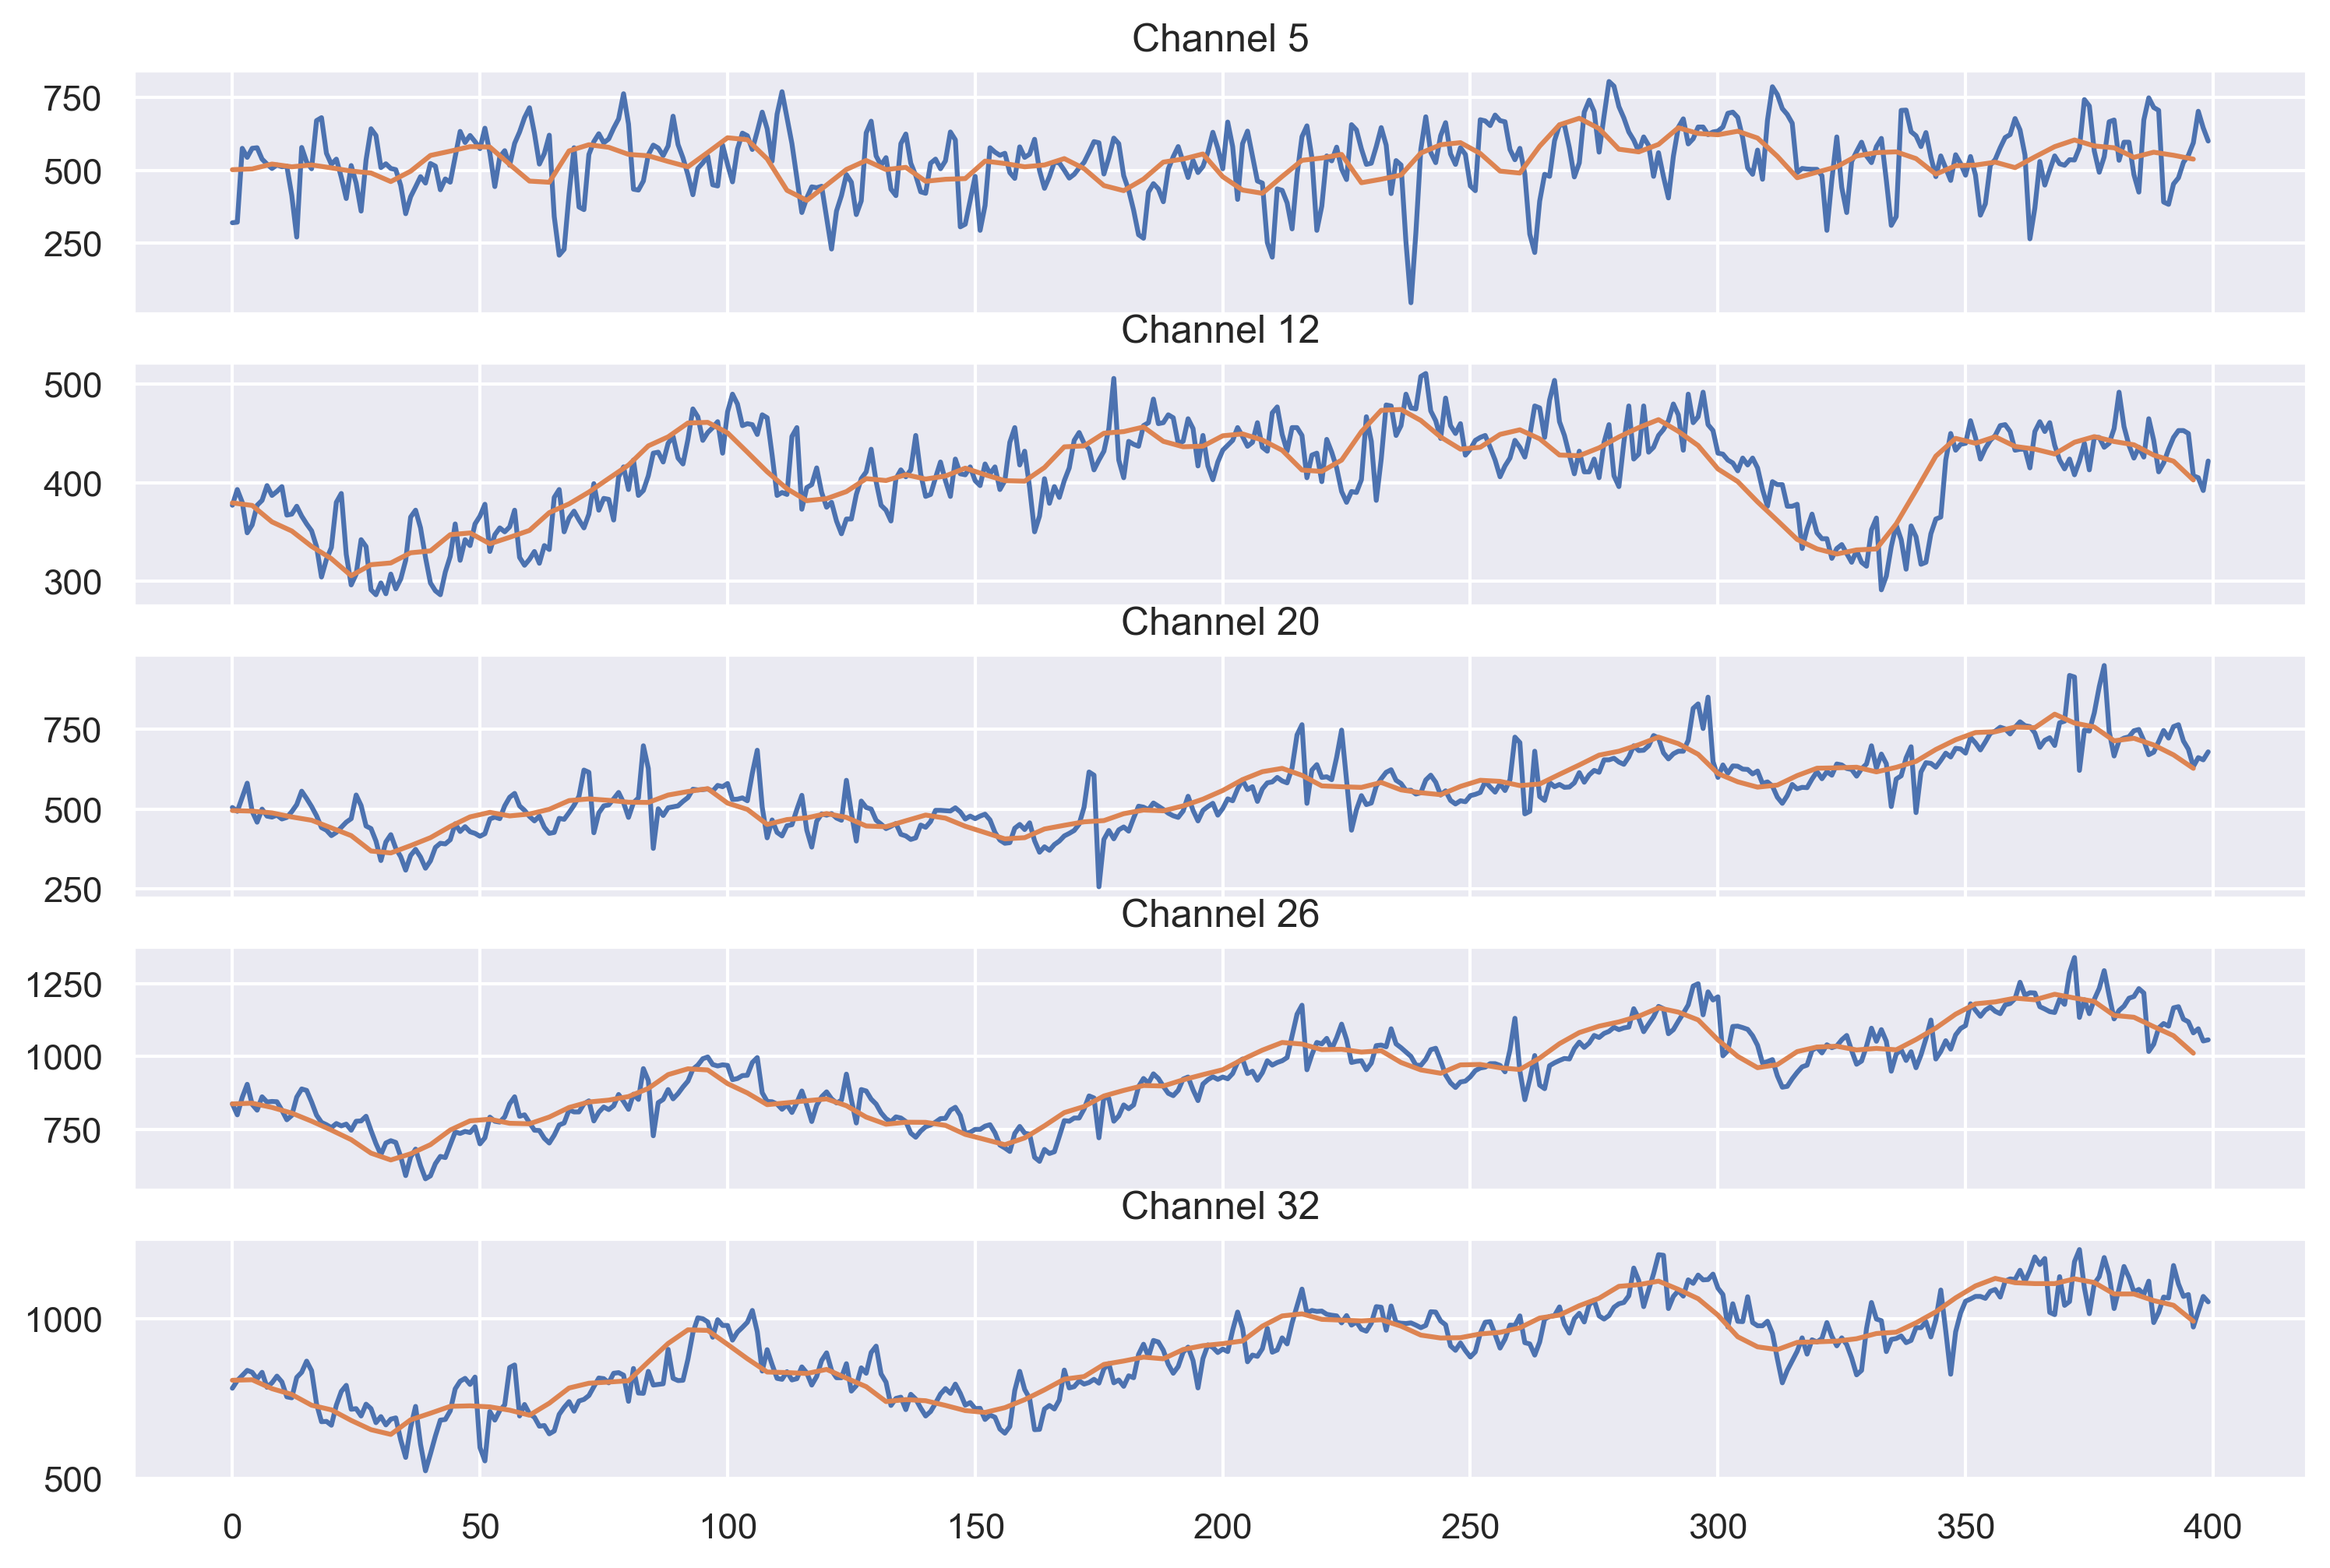

In [34]:
###PLotting data samples
t = X_train[1200:1600,30]
t_seg = X_train_seg[300:400,30]
time = range(0,400)
time_seg = range(0,400,slide_len)

fig,a =  plt.subplots(5,1)
a[0].plot(time,X_train[1200:1600,5])
a[0].plot(time_seg,X_train_seg[300:400,5])
a[0].set_title('Channel 5')
a[0].set_xticklabels([])

a[1].plot(time,X_train[1200:1600,12])
a[1].plot(time_seg,X_train_seg[300:400,12])
a[1].set_title('Channel 12')
a[1].set_xticklabels([])

a[2].plot(time,X_train[1200:1600,20])
a[2].plot(time_seg,X_train_seg[300:400,20])
a[2].set_title('Channel 20')
a[2].set_xticklabels([])

a[3].plot(time,X_train[1200:1600,26])
a[3].plot(time_seg,X_train_seg[300:400,26])
a[3].set_title('Channel 26')
a[3].set_xticklabels([])

a[4].plot(time,X_train[1200:1600,31])
a[4].plot(time_seg,X_train_seg[300:400,31])
a[4].set_title('Channel 32')

Normalising Data, Variance of every channel is set to 1.

In [6]:
###Data normalising
sc = StandardScaler()

X_train_seg = sc.fit_transform(X_train_seg)

X_train_seg =np.asarray(X_train_seg.astype(float))
Y_train_seg = np.asarray(Y_train_seg.astype(float))

print(X_train_seg.shape)

(361871, 32)


**Classifier Training**: Classifiers are trained for varying training samples: from 50 to 100,000. Each training set is sampled three times with varying data for each sample. The results are stored in a csv file: **eeg_grasp_pre_lhat_baac_bin6.csv**. The results for classifier type, number of samples, lhat (mean test error) error, average precision, balanced accuracy, train time, test time and sample number are written in the above mentioned file.


In [ ]:
###Training
names = {"kNN": "black", "RF":"blue", "MLP":"green", "S-RerF":"red"}

ncores=1
num_runs=3
n_est=100
filename = 'eeg_grasp_pre_lhat_baac_bin6.csv'

classifiers = [KNeighborsClassifier(3, n_jobs=ncores),
               RandomForestClassifier(n_estimators=n_est, max_features='auto', n_jobs=ncores),
               MLPClassifier(hidden_layer_sizes=(100, ), random_state=0, max_iter=1000),
               rerfClassifier(projection_matrix="S-RerF",
                   max_features=40,
                   n_jobs=ncores,
                    n_estimators=n_est,
                    oob_score=False,
                    random_state=0,
                    image_height=1,
                    image_width=32,
                    patch_height_max=1,
                    patch_height_min=1,
                    patch_width_max=10,
                    patch_width_min=1
                   )
    ]

# Train each classifier on each data set size, then test
## Prep output file:
f = open(filename, 'w+')
f.write("classifier,n,Lhat,Precision,BACC,trainTime,testTime,iterate\n")
f.flush()

ns = np.array([50,500,5000,50000,100000])
runList = [(clf) for clf in zip(classifiers, [key for key in names])]
for n in tqdm(ns):
    print (n)
    for iteration in tqdm(range(num_runs)):
        
        #sampling of data
        X_train1, X_test1, Y_train1, Y_test1 = train_test_split(
        X_train_seg, Y_train_seg, train_size=100000, test_size=10000)
        ns_block = [50,500,5000,50000,100000]
        X_train2, Y_train2 = sort_keep_balance(X_train1, Y_train1, ns_block)
        
        X = X_train2[:n,:]
        y = Y_train2[:n]

        print (iteration)
        for clf in tqdm(runList):
            
            #training
            trainStartTime = time.time()
            clf[0].fit(X, y)
            trainEndTime = time.time()
            trainTime = trainEndTime - trainStartTime
            #prediction
            testStartTime = time.time()
            out = clf[0].predict(X_test1)
            testEndTime = time.time()
            testTime = testEndTime - testStartTime
            #lhat error
            lhat = np.mean(np.not_equal(out, Y_test1).astype(int))
            #avg precision
            Y_test1 = np.asarray(Y_test1)
            out = np.asarray(out)
            y_val_true, val_pred = Y_test1.reshape((-1)), out.reshape((-1))
            avg_precision = average_precision_score(y_val_true, val_pred)
            
            #balanced accuracy score
            bal_acc = balanced_accuracy_score(Y_test1, out)
            
            #writing to file
            ####("variable,num of training samples,Lhat,avg precision,trainTime,testTime,iterate")
            f.write(f"{clf[1]}, {n}, {lhat:2.9f},{avg_precision:2.9f}, {bal_acc:2.9f}, 
                    {trainTime:2.9f}, {testTime:2.9f}, {iteration}\n")
            f.flush()
f.close()

**Results and Plots** : The metrics used for comparison are precision curves, balanced accuracy curves and mean test error curves. As the data is unbalanced, normal accuracy cannot be used as a measure so we have to used balanced accuracy and precision which gives us better information about classifiers performance.

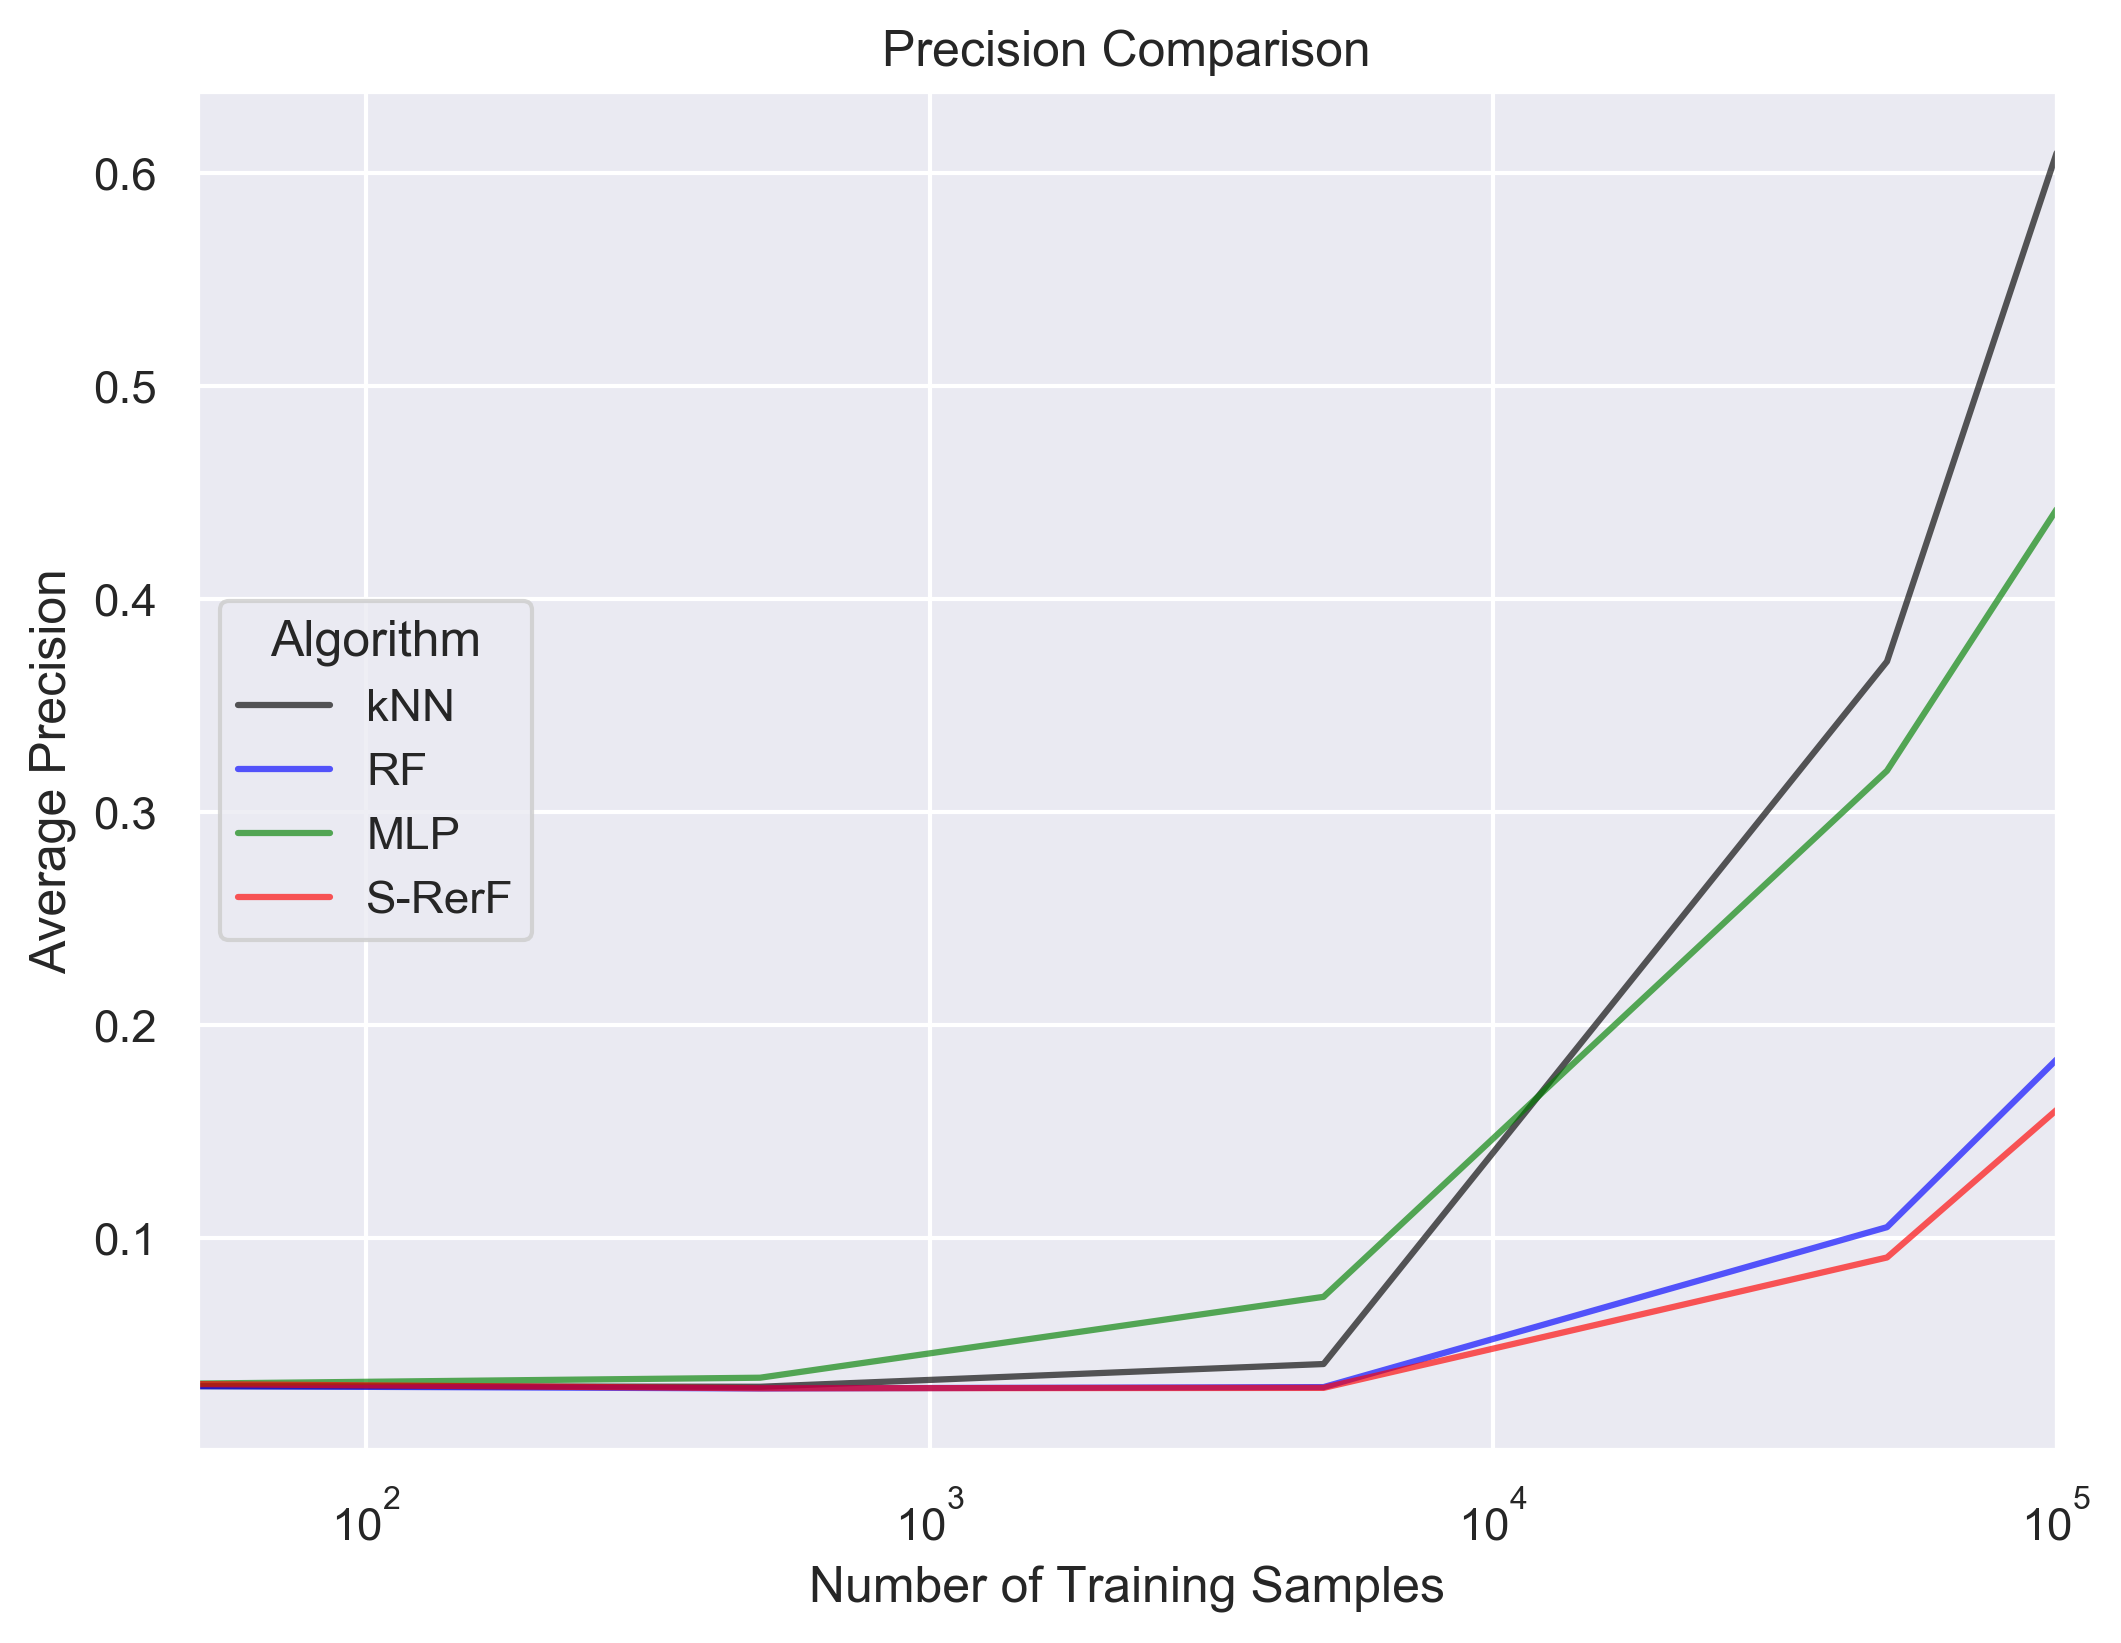

In [35]:
filename = "eeg_grasp_pre_lhat_baac_bin6.csv"
names = {"kNN": "black", "RF":"blue", "MLP":"green", "S-RerF":"red"}
dat = pd.read_csv(filename)

##Plot Average Precision
plot_data(dat,'Precision','Average Precision','Precision Comparison')


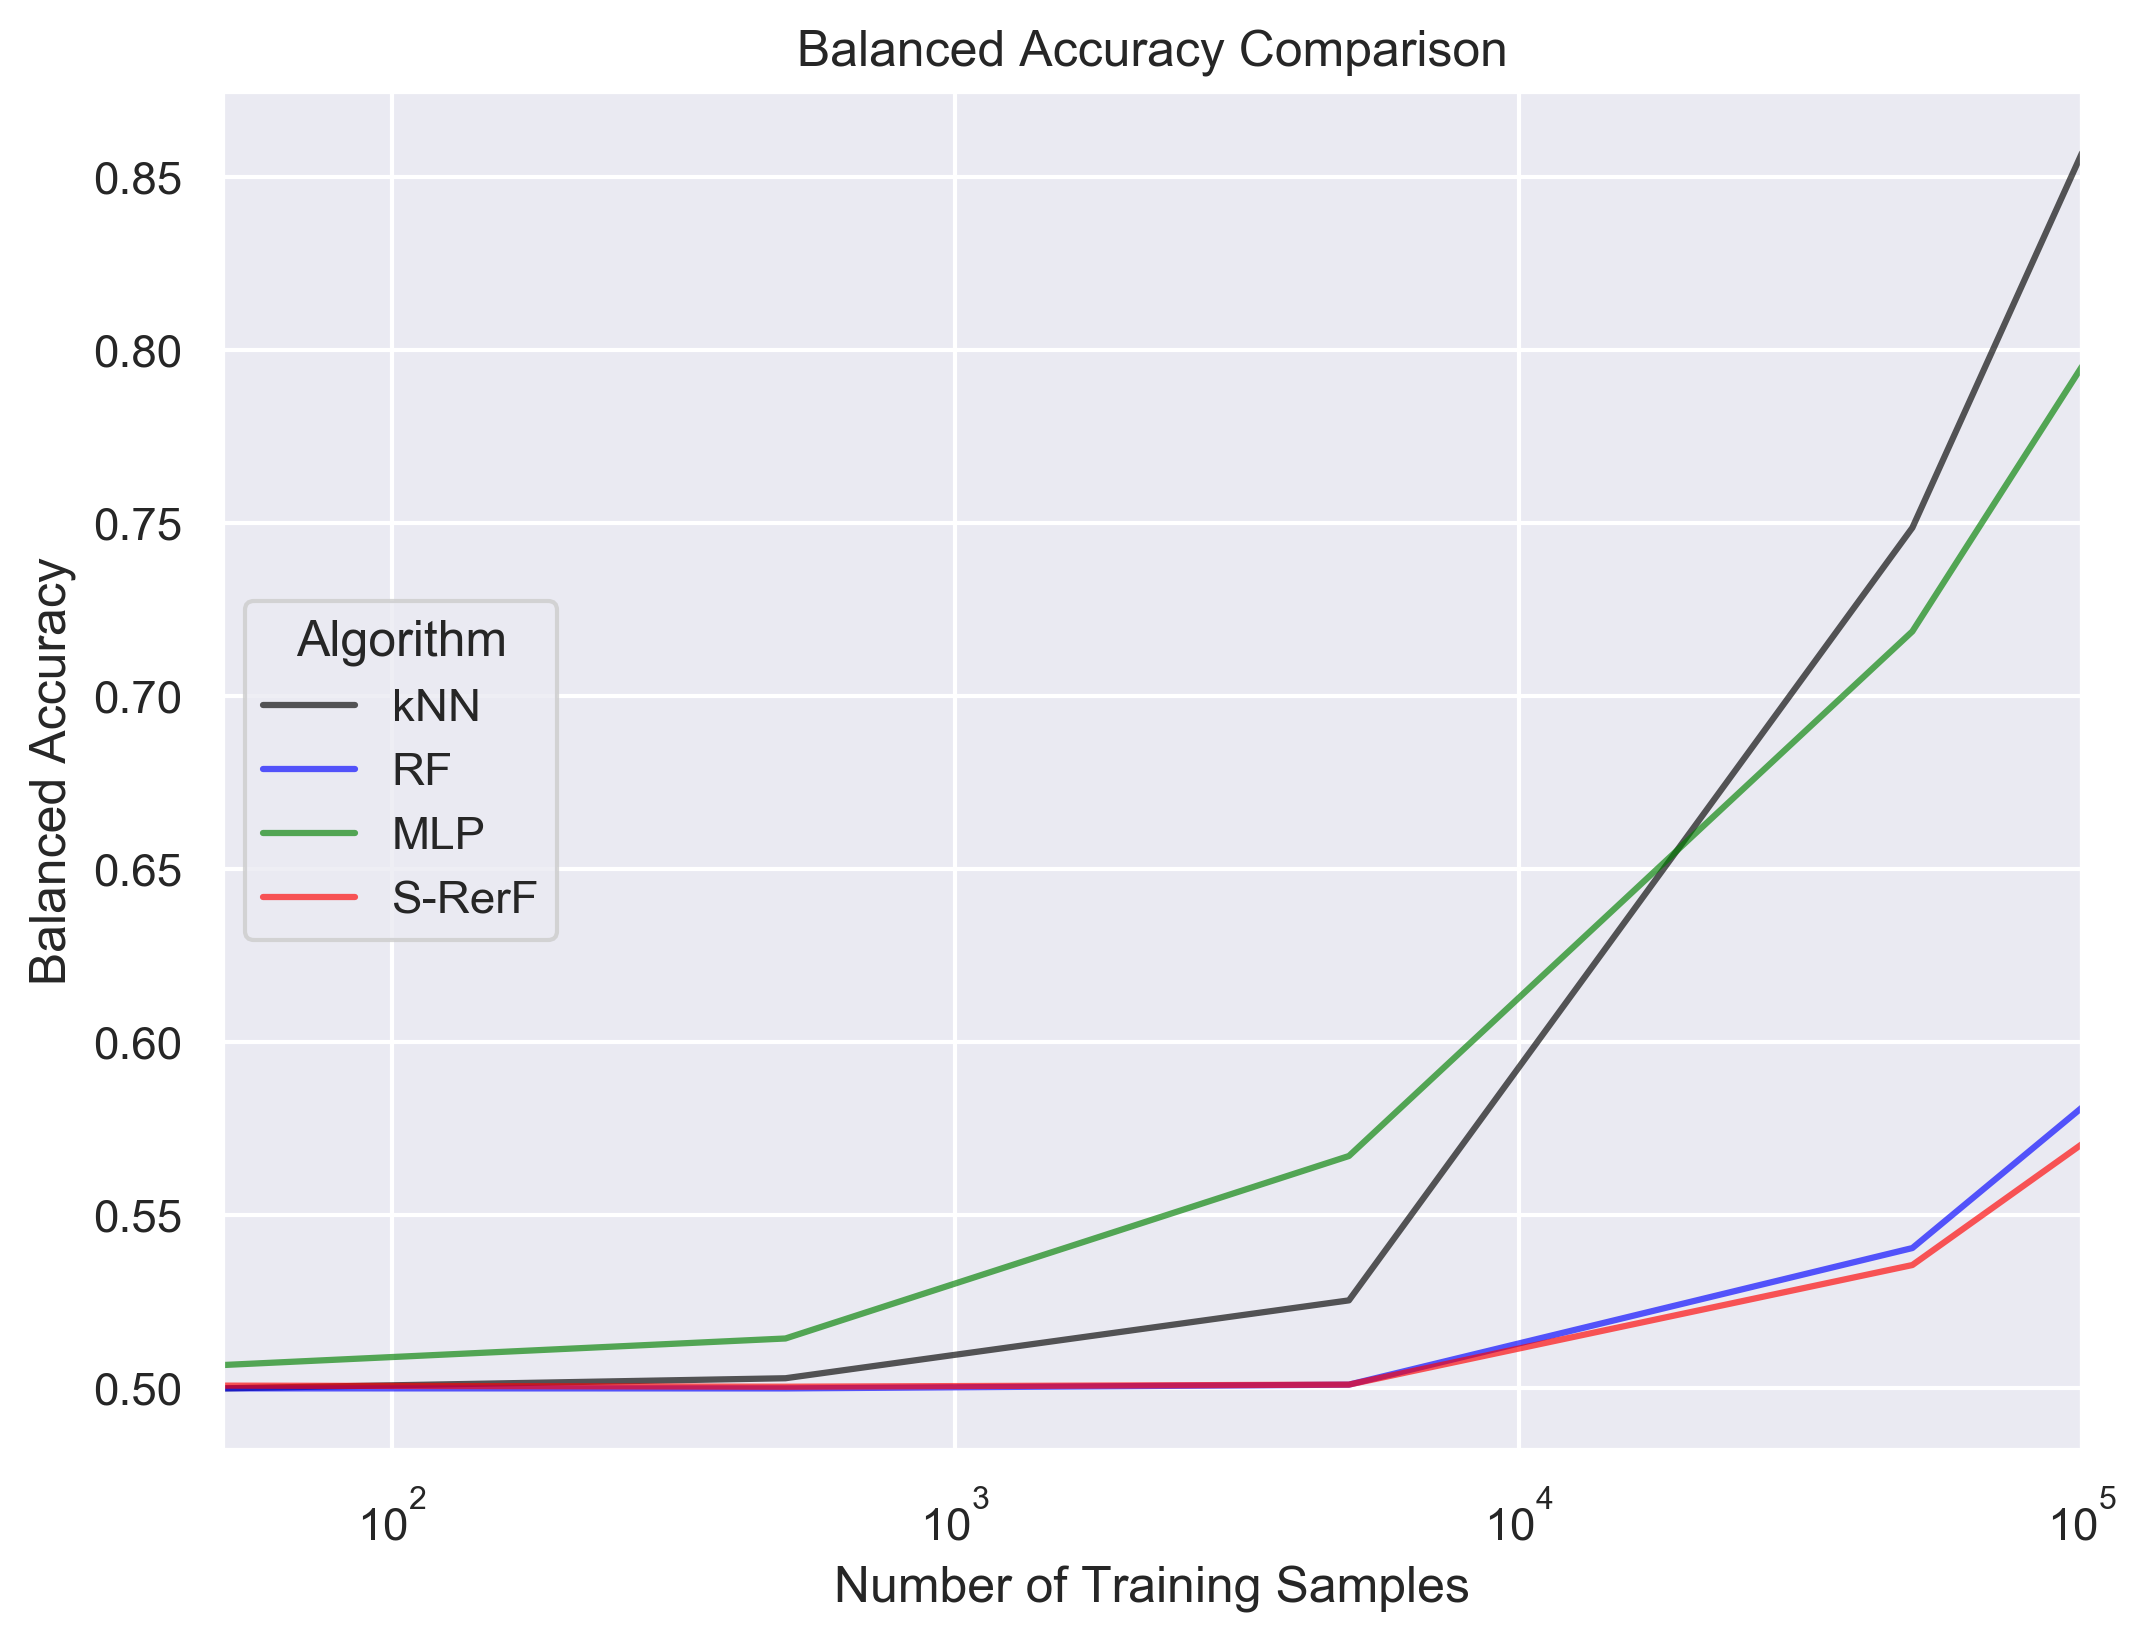

In [36]:
##PLot Balanced Test Accuracy
plot_data(dat,'BACC','Balanced Accuracy','Balanced Accuracy Comparison')

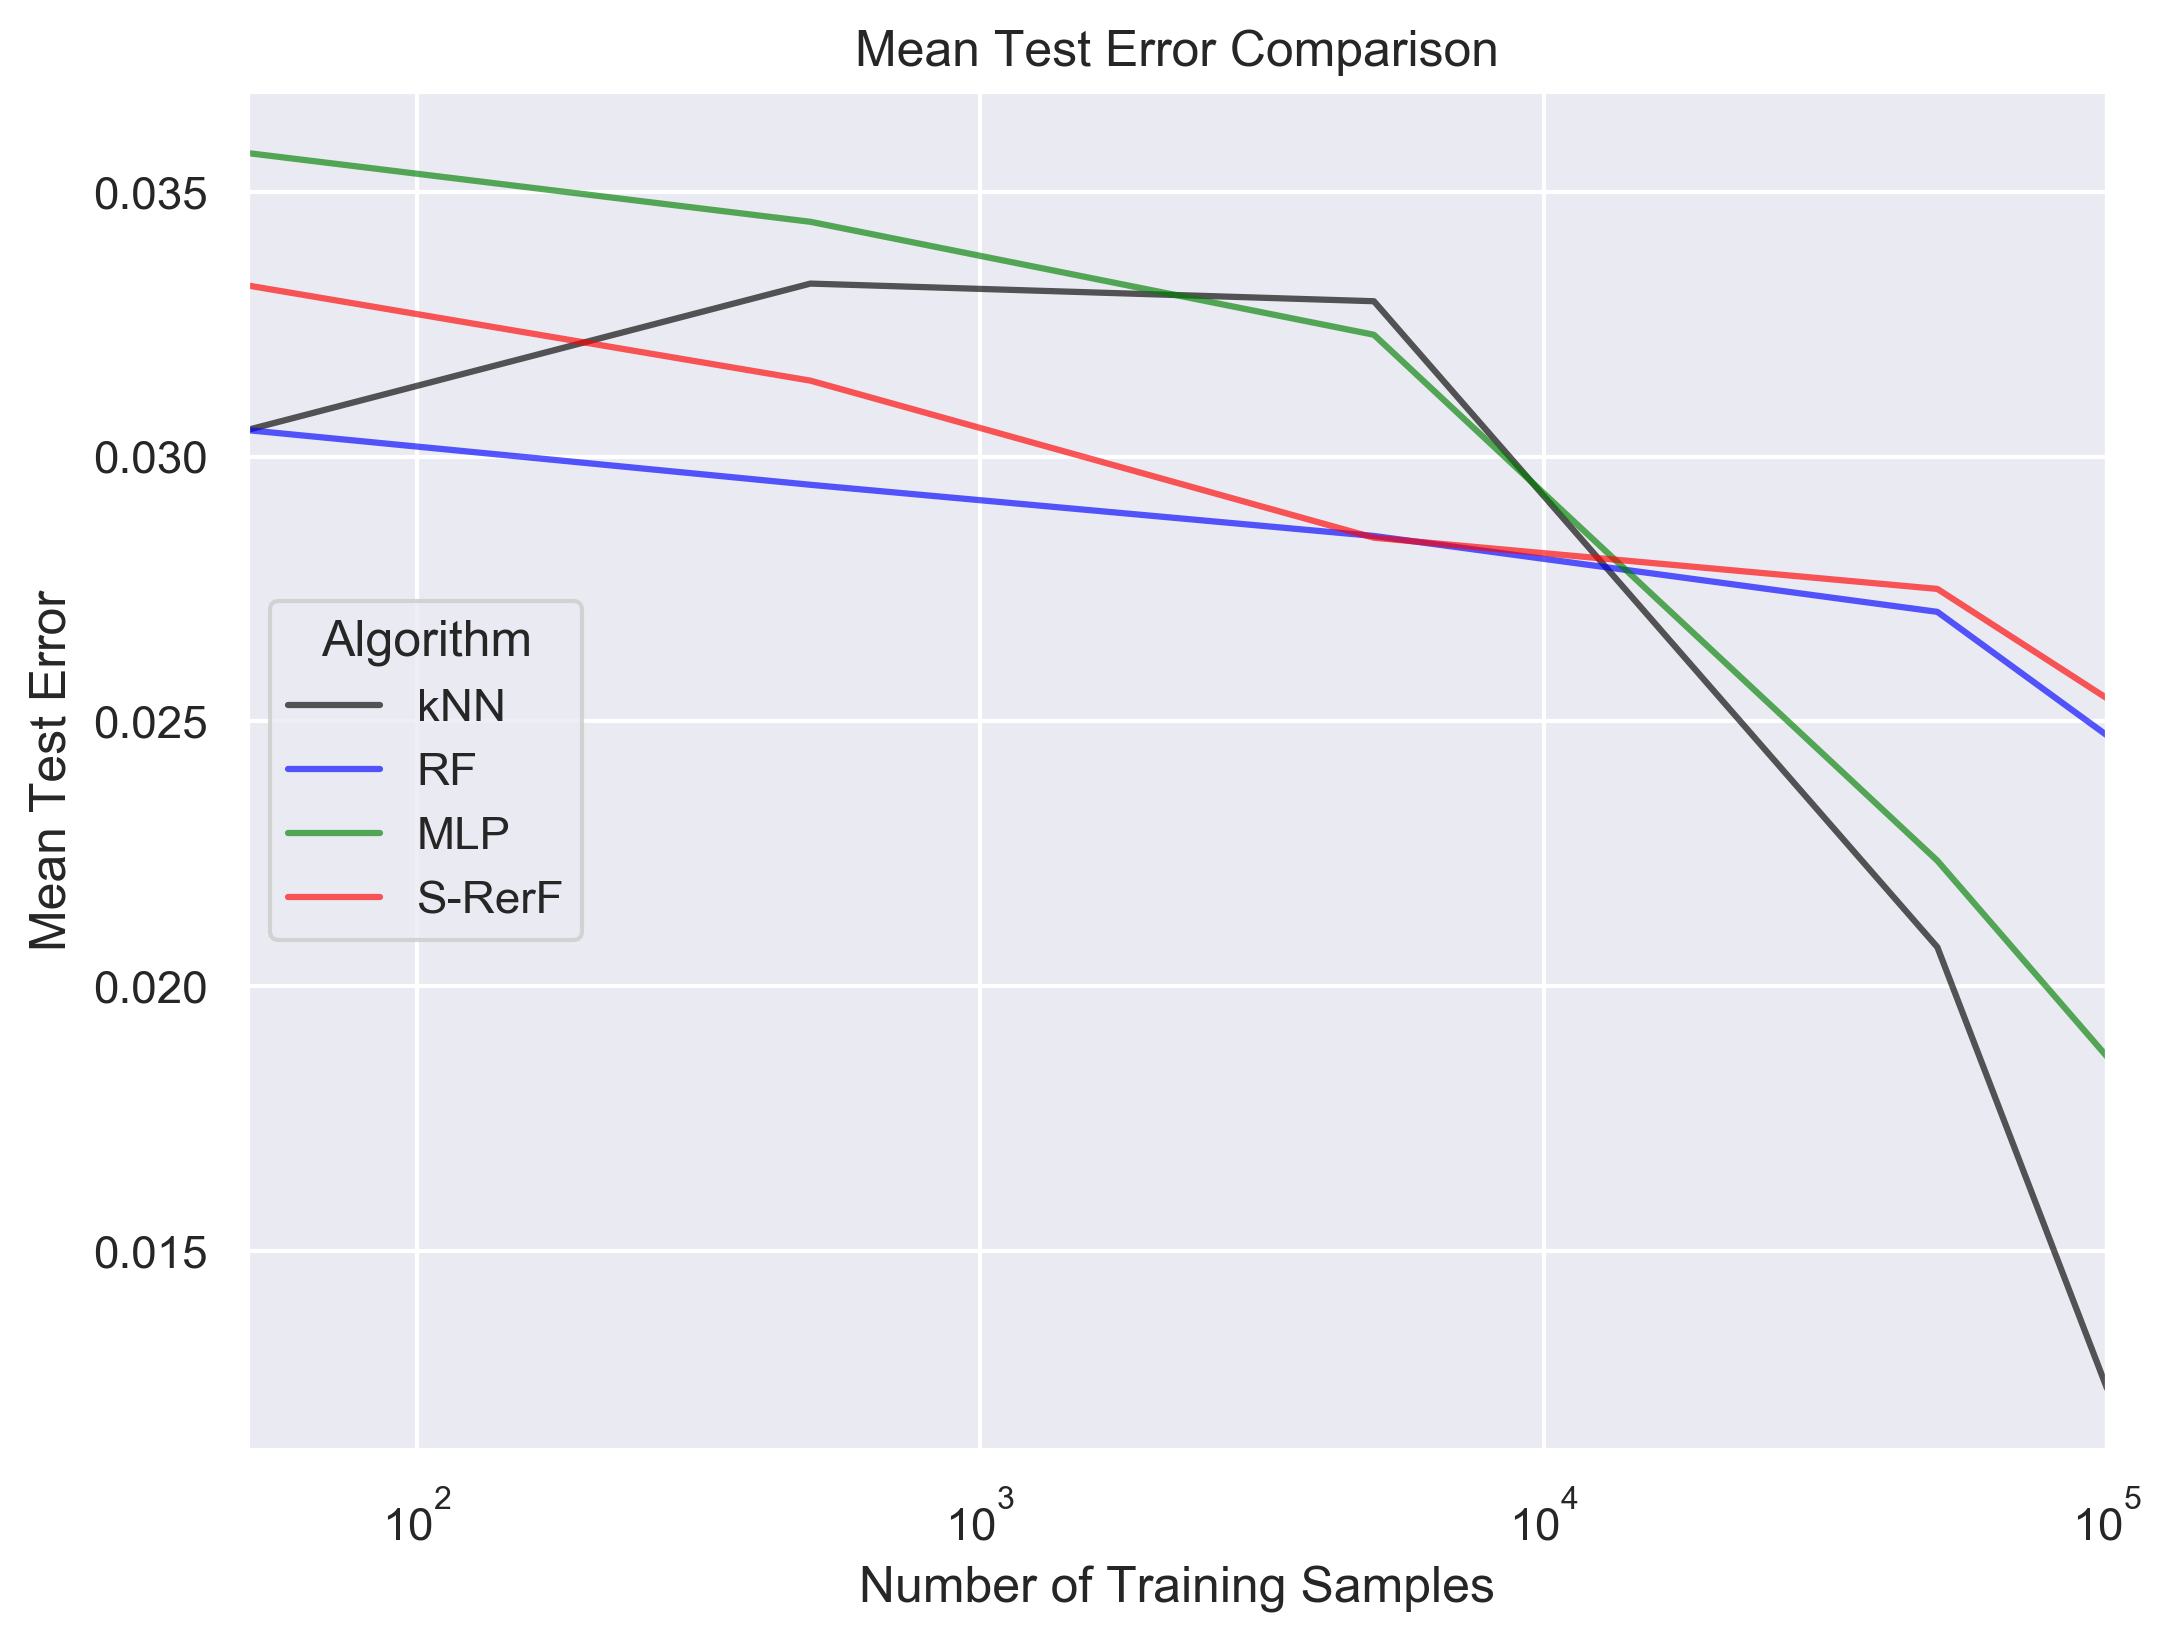

In [37]:
##Plot Mean Test Error
plot_data(dat,'Lhat','Mean Test Error','Mean Test Error Comparison')